Back in high school, I competed in [Moody's Mega Math Challenge](https://m3challenge.siam.org/), a super interesting math modeling competition (and the thing that got me into Python's data stack). Essentially, you're given a 14 hours to write up a paper (working in teams of 5) to open a super open-ended question. In my senior year, the question was about [school lunches](https://m3challenge.siam.org/sites/default/files/uploads/m3challenge_problem_14_Sat.pdf). One of the most surprising result I found was that schoolgirls ate the same amount of calories (on average), regardless of their grade level.

One of my friends recently asked me for that analysis. Unfortunately, I don't think the files survived the hard-drive apocalypse of late 2015, so I settled with reproducing it here. I've always wondered whether that result was real or whether it was just me messing up, so this was a perfect excuse to find out.

One interesting thing I noticed was that this analysis was _so much easier_ now. I distinctly remember taking a couple hours figuring out how to massage the data into appropriate formats -- now, it took me like 20 minutes to do everything, from data cleaning and munging to analysis and graphing. It's nice to know that I've improved!

The data comes from the [NHANES](http://www.cdc.gov/Nchs/Nhanes/index.htm) survey from the [CDC](http://www.cdc.gov/). To quote their website:

> The National Health and Nutrition Examination Survey (NHANES) is a program of studies designed to assess the health and nutritional status of adults and children in the United States

Although the latest full data set they have is from 2011-12, I distinctly remember using the 2009-2010 data back then (and being frustrated that more recent data wasn't available), so let's use the 2009-2010 data sets.

Let's go ahead and download the Total Nutriet Intake, Day One data set, along with the corresponding demographic data set. The documentation for the two data sets can be found at: 
- http://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/DEMO_F.htm
- http://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/DR1TOT_F.htm

In [1]:
!wget --continue http://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/DR1TOT_F.XPT
!wget --continue http://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/DEMO_F.XPT

--2016-07-10 19:13:06--  http://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/DR1TOT_F.XPT
Resolving wwwn.cdc.gov (wwwn.cdc.gov)... 198.246.117.100
Connecting to wwwn.cdc.gov (wwwn.cdc.gov)|198.246.117.100|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2016-07-10 19:13:06--  http://wwwn.cdc.gov/Nchs/Nhanes/2009-2010/DEMO_F.XPT
Resolving wwwn.cdc.gov (wwwn.cdc.gov)... 198.246.117.100
Connecting to wwwn.cdc.gov (wwwn.cdc.gov)|198.246.117.100|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [2]:
import pandas as pd
from dplython import X, DplyFrame, sift, select, mutate

In [3]:
food_df = DplyFrame(pd.read_sas("DR1TOT_F.XPT"))
demographic_df = DplyFrame(pd.read_sas("DEMO_F.XPT"))

In [4]:
schoolgirls_df = (demographic_df
                  >> sift(X.DMDSCHOL.isin({1, 2, 3}))   # still in school
                  >> sift(X.RIAGENDR == 2)              # female
                  >> mutate(gradelevel=X.DMDEDUC3.astype(int),
                            SEQN=X.SEQN.astype(int),
                            age=X.RIDAGEMN.astype(int) / 12.0)   # age is in months
                  >> select(X.gradelevel, X.SEQN, X.age)).set_index("SEQN")

In [5]:
diets_df = (food_df
            >> sift(X.SEQN.isin(schoolgirls_df.index))
            >> mutate(calories=X.DR1TKCAL,
                      weight=X.WTDRD1,
                      SEQN=X.SEQN.astype(int))
            >> select(X.SEQN, X.weight, X.calories)).set_index("SEQN")

In [6]:
df = pd.concat([schoolgirls_df, diets_df], axis=1).dropna()
df.head()

,gradelevel,age,weight,calories
SEQN,,,,
51649,3,8.916667,8783.597646,2276.0
51650,4,11.583333,24375.827738,1371.0
51651,13,19.333333,30516.488003,1411.0
51663,13,18.833333,7298.041244,1313.0
51671,2,9.333333,5594.785512,1073.0


We've known obtained some clean data (although we've deliberately thrown out some potentially useful data)

In [7]:
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
%matplotlib inline

/home/alan/anaconda/envs/nutrition/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


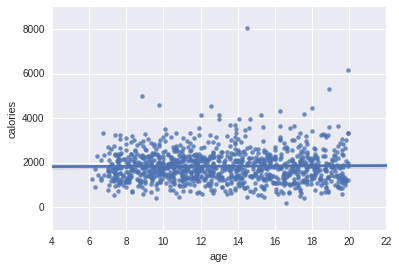

In [8]:
sns.regplot(x="age", y="calories", data=df)

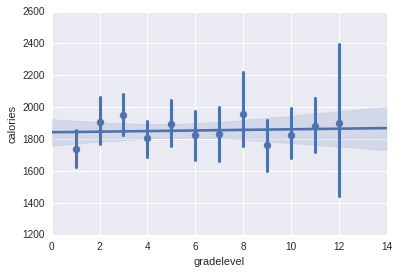

In [9]:
sns.regplot(x="gradelevel", y="calories", data=df[df.gradelevel < 13],
            x_estimator=np.mean, x_ci=95)

# blue bars are 95% confidence intervals of the mean at those grade levels
# shaded blue is 95% CI for linear regression line

In [10]:
model = smf.ols(formula="calories ~ age + 1", data=df)
results = model.fit()
print(results.summary())
print()

                            OLS Regression Results                            
Dep. Variable:               calories   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1637
Date:                Sun, 10 Jul 2016   Prob (F-statistic):              0.686
Time:                        19:19:34   Log-Likelihood:                -8419.7
No. Observations:                1050   AIC:                         1.684e+04
Df Residuals:                    1048   BIC:                         1.685e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1821.5405     83.921     21.705      0.0

In [11]:
model = smf.ols(formula="calories ~ gradelevel + 1", data=df[df.gradelevel < 13])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               calories   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.06605
Date:                Sun, 10 Jul 2016   Prob (F-statistic):              0.797
Time:                        19:19:40   Log-Likelihood:                -7663.6
No. Observations:                 957   AIC:                         1.533e+04
Df Residuals:                     955   BIC:                         1.534e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1843.2170     48.476     38.023      0.0

We're done, right?

Unfortunately, no. Although I'm pretty sure this was the analysis I ran back in high school, this second time around I noticed a problem -- each respondant from NHANES is actually given a sample weight, which might throw off the entire analysis.

Let's redo the analysis by taking advantage of the sample weights. Becuse I'm lazy, instead of a more sophisticated analysis, I'm just going to resample the dataframe using the weights provided. This will almost certainly lead to flawed confidence intervals, but like I said, I'm lazy.

See these two papers for more info about properly dealing with sampling weights and regression:
- http://www.nber.org/papers/w18859
- http://www.stat.columbia.edu/~gelman/research/published/STS226.pdf

In [12]:
weighted_df = df.sample(df.weight.sum().astype(int), replace=True, weights=df.weight)
# weighted_df = df.loc[np.repeat(df.index.values, df.weight.round().astype(int))]

# Because of how many data points there are, I'll not bother with the graphs.

In [13]:
model = smf.ols(formula="calories ~ age + 1", data=weighted_df)
results = model.fit()
print(results.summary())
print()

                            OLS Regression Results                            
Dep. Variable:               calories   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     360.9
Date:                Sun, 10 Jul 2016   Prob (F-statistic):           1.76e-80
Time:                        19:19:56   Log-Likelihood:            -2.1456e+08
No. Observations:            26869246   AIC:                         4.291e+08
Df Residuals:                26869244   BIC:                         4.291e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1811.0347      0.530   3414.205      0.0

In [14]:
model = smf.ols(formula="calories ~ gradelevel + 1", data=weighted_df[weighted_df.gradelevel < 13])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               calories   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     7.332
Date:                Sun, 10 Jul 2016   Prob (F-statistic):            0.00677
Time:                        19:20:15   Log-Likelihood:            -1.9258e+08
No. Observations:            24169700   AIC:                         3.852e+08
Df Residuals:                24169698   BIC:                         3.852e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1815.5089      0.311   5840.708      0.0

Even with after resampling the weights, I stand by my conclusion: age and grade level *don't* seem to affect daily caloric consumption. Even though the coefficients are technically significant, a <1 calorie difference per year is essentially negligible.